# 데이터 살펴보기

## 데이터 다운로드 받기

In [ ]:
from tensorflow.keras.datasets import cifar10

# 데이터를 다운받습니다.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

## 데이터 그려보기

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(777)

class_names = ['airplane', 'automobile', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse',
              'ship', 'truck']

sample_size = 9
random_idx = np.random.randint(60000, size=sample_size) 

plt.figure(figsize = (5, 5))

for i, idx in enumerate(random_idx):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap = 'gray')
    plt.xlabel(class_names[int(y_train[i])])
    
plt.show()

## 전처리 과정

In [ ]:
# 평균과 표준편차는 채널별로 구해줍니다.
x_mean = np.mean(x_train, axis = (0, 1, 2))
x_std = np.std(x_train, axis = (0, 1, 2))

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size = 0.3, random_state = 777)

print(x_train.shape, len(y_train))
print(x_val.shape, len(y_val))

# 신경망 학습시키기 

## 모델 구성하기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential()
# (32, 32, 3)의 데이터를 입력으로 받습니다. 
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10, activation = 'softmax')) # 10개의 출력을 가지는 신경망

model.compile(optimizer = Adam(1e-4),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

## 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train,
                    epochs = 30,
                    batch_size = 32,
                    validation_data = (x_val, y_val))

## 학습 과정 그려보기

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

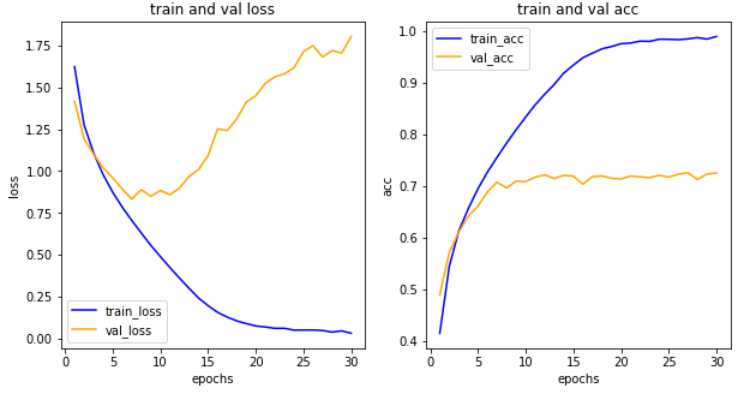

## 신경망 시각화해보기

In [ ]:
import tensorflow as tf

get_layer_name = [layer.name for layer in model.layers]
get_output = [layer.output for layer in model.layers]

# 모델 전체에서 output을 가져올 수 있습니다.
visual_model = tf.keras.models.Model(inputs = model.input, outputs = get_output)

# 테스트셋의 두 번째 데이터는 '배'입니다.
test_img = np.expand_dims(x_test[1], axis = 0)
feature_maps = visual_model.predict(test_img)

for layer_name, feature_map in zip(get_layer_name, feature_maps):
    # Dense 층은 제외합니다.
    if(len(feature_map.shape) == 4):
        img_size = feature_map.shape[1]
        features = feature_map.shape[-1]
        
        # (img_size, img_size)의 feature_map이 features 개수만큼 존재합니다.
        display_grid = np.zeros((img_size, img_size * features))
        
        # 각 특징맵을 display_grid 배열에 이어붙입니다.
        for i in range(features):
            x = feature_map[0, :, :, i]
            x -= x.mean(); x /= x.std()
            x *= 64; x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * img_size : (i + 1) * img_size] = x
            
        plt.figure(figsize = (features, 2 + 1./features))
        plt.title(layer_name, fontsize = 20)
        plt.grid(False)
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')